# Summary

This EDA explores relationship between features of a house and its price. The follwing insights have been obtained:

+ Sale prices tend to increase with living area, garage area and age of the house
+ Sale prices tend to drop when residential density increases

+ Neighborhood has __very strong impact__ on price

+ Sale price depends on which type of street a house is adjacent to and whether it is close to a park/greenbelt. Especially, if a house is near an arterial street, its price will be dropped, most likely due to problems such as air and noise pollutions.

A comparison between expensive houses and cheap houses is also provided in Section 3.4.

Last but not least, I have provided a __quantifiable way__ to measure for relationship between sale price and categorical features, which is not easily found in many common notebooks.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# folder = '/kaggle/input/house-prices-advanced-regression-techniques/'
folder = 'data'

train = pd.read_csv(os.path.join(folder, 'train.csv'))
test = pd.read_csv(os.path.join(folder, 'test.csv'))

print(train.shape)
print(test.shape)

train.head()

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# lowercase all column names for convenience
train.columns = [str.lower(cc) for cc in train.columns]
test.columns = [str.lower(cc) for cc in test.columns]

In [5]:
test['saleprice'] = 0
data = pd.concat([train, test])

In [6]:
# sale price in thousands is better for plotting
data['saleprice_in_thousand'] = data['saleprice']/(10**3)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2919 non-null   int64  
 1   mssubclass             2919 non-null   int64  
 2   mszoning               2915 non-null   object 
 3   lotfrontage            2433 non-null   float64
 4   lotarea                2919 non-null   int64  
 5   street                 2919 non-null   object 
 6   alley                  198 non-null    object 
 7   lotshape               2919 non-null   object 
 8   landcontour            2919 non-null   object 
 9   utilities              2917 non-null   object 
 10  lotconfig              2919 non-null   object 
 11  landslope              2919 non-null   object 
 12  neighborhood           2919 non-null   object 
 13  condition1             2919 non-null   object 
 14  condition2             2919 non-null   object 
 15  bldg

## Helper methods

In [9]:
def cal_age_from_built(row):
    return row['yrsold'] - row['yearbuilt']

def cal_age_from_remodel(row):
    return row['yrsold'] - row['yearremodadd']

RED_BLUE = plt.get_cmap('RdBu')
def plot_corr_matrix(data, annotate=False, color_map=RED_BLUE, center=0):
    sns.set_style('white')
    # Compute the correlation matrix
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,
                cmap=color_map, cbar_kws={"shrink": .5},
#                 vmax=.3, 
                center=center,
                square=True, linewidths=.5,
                annot=annotate
                )

def fold_zone_type(ms_zone):
    if ms_zone in ['FV', 'RH', 'C (all)']:
        return 'Other'
    else:
        return ms_zone
#         return {'RL': 'Residential Low Density'.lower() , 
#                 'RM': 'Residential Medium Density'.lower(),
#                 None: 'NA'
#                }[ms_zone]    

def to_adjacency(cond):
    if 'RR' in cond:
        return 'Railroad'
    if 'Pos' in cond:
        return 'Positive feature'
    return {
        'Artery': 'Arterial street',
        'Feedr': 'Feeder street',
        'Norm': 'Normal'    
        }[cond]

In [10]:
def list_numeric_columns(data):
    return list(data.columns[np.where(data.dtypes != 'object')])

def list_string_columns(data):
    return list(data.columns[np.where(data.dtypes == 'object')])

def split_train_valid(data, target):
    y = data.pop(target)
    X = data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.1, 
                                                          random_state=1
                                                         )
    return X_train, X_valid, y_train, y_valid

def check_na(data):
    # return the columns having NAs, sorted descendingly by their number of NAs
    na_count = [sum(data[ff].isnull()) for ff in data.columns]
    return pd.DataFrame({'column': data.columns, 'na_count': na_count}).\
              query('na_count > 0').sort_values('na_count', ascending=False)  

In [11]:
train['zone_type'] = train['mszoning'].apply(fold_zone_type)
test['zone_type'] = test['mszoning'].apply(fold_zone_type)

## Sale price distribution

In [10]:
target = 'saleprice_in_thousand'

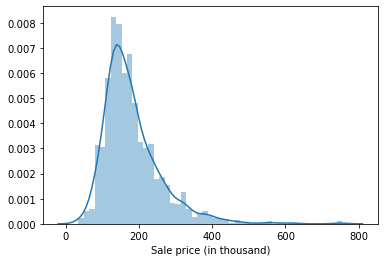

In [11]:
# price hist
p_hist = sns.distplot(train[target] , axlabel='Sale price (in thousand)')

Most prices are in range 100-200K.

In [12]:
train[target].describe()

count    1460.000000
mean      180.921196
std        79.442503
min        34.900000
25%       129.975000
50%       163.000000
75%       214.000000
max       755.000000
Name: saleprice_in_thousand, dtype: float64

While most sale prices are <= 220K, there are some exceeding that. Are they out liers?

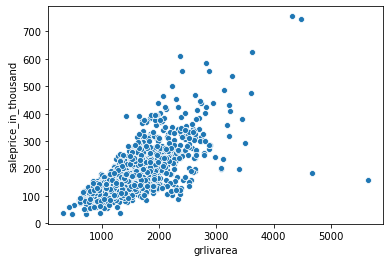

In [17]:
sale_vs_area = sns.scatterplot(data=train, x='grlivarea', y=target)

There seems to be 5 outliers, 3 with very big prices and 2 with big areas. I will temp exclude them, but before that, let us look at sale price per square feet, as this should be a fair measurement for house price regardless of their area. Actually buyers also use price per square feet as a comparison between houses.

In [18]:
# Should we use sale price per square feet instead?
train['sale_price_per_sf'] = train['saleprice'] / train['grlivarea']
train['sale_price_per_sf'].describe()

count    1460.000000
mean      120.572878
std        31.391081
min        28.358738
25%        99.822008
50%       120.099031
75%       138.700041
max       276.250881
Name: sale_price_per_sf, dtype: float64

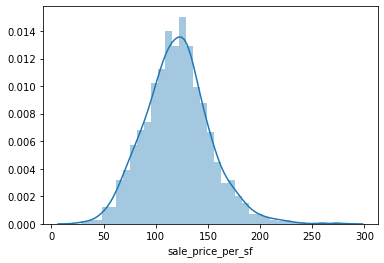

In [19]:
dp = sns.distplot(train.sale_price_per_sf)

This looks very similar to a normal distribution. So maybe sale price per square feet is a better target variable.

# Sale price vs. numeric features

In [32]:
# what are existing numeric vars?
num_vars = list(train.columns[np.where( train.dtypes != 'object')])
print('# numeric vars: ', len(num_vars))
print(num_vars)

# numeric vars:  42
['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice', 'saleprice_in_thousand', 'sale_price_per_sf', 'age_from_built', 'age_from_remodel']


+ Excluding 'Id', 'MSSubClass', the remaining vars are interested vars. Most of them are related to some kind of area.

+ some vars are related to year built and month/year sold --> a derived feature is age at selling time.

In [34]:
train['age_from_built'] = train.apply(axis=1, func=cal_age_from_built)
test['age_from_built'] = test.apply(axis=1, func=cal_age_from_built)
train['age_from_remodel'] = train.apply(axis=1, func=cal_age_from_remodel)
test['age_from_remodel'] = test.apply(axis=1, func=cal_age_from_remodel)

## Sale price vs. areas

In [35]:
area_vars = [s for s in num_vars if 'area' in s]
print(area_vars)
train[area_vars].describe()

['lotarea', 'masvnrarea', 'grlivarea', 'garagearea', 'poolarea']


,lotarea,masvnrarea,grlivarea,garagearea,poolarea
count,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,103.685262,1515.463699,472.980137,2.758904
std,9981.264932,181.066207,525.480383,213.804841,40.177307
min,1300.000000,0.000000,334.000000,0.000000,0.000000
25%,7553.500000,0.000000,1129.500000,334.500000,0.000000
50%,9478.500000,0.000000,1464.000000,480.000000,0.000000
75%,11601.500000,166.000000,1776.750000,576.000000,0.000000
max,215245.000000,1600.000000,5642.000000,1418.000000,738.000000


['lotarea', 'masvnrarea', 'grlivarea', 'garagearea', 'poolarea']


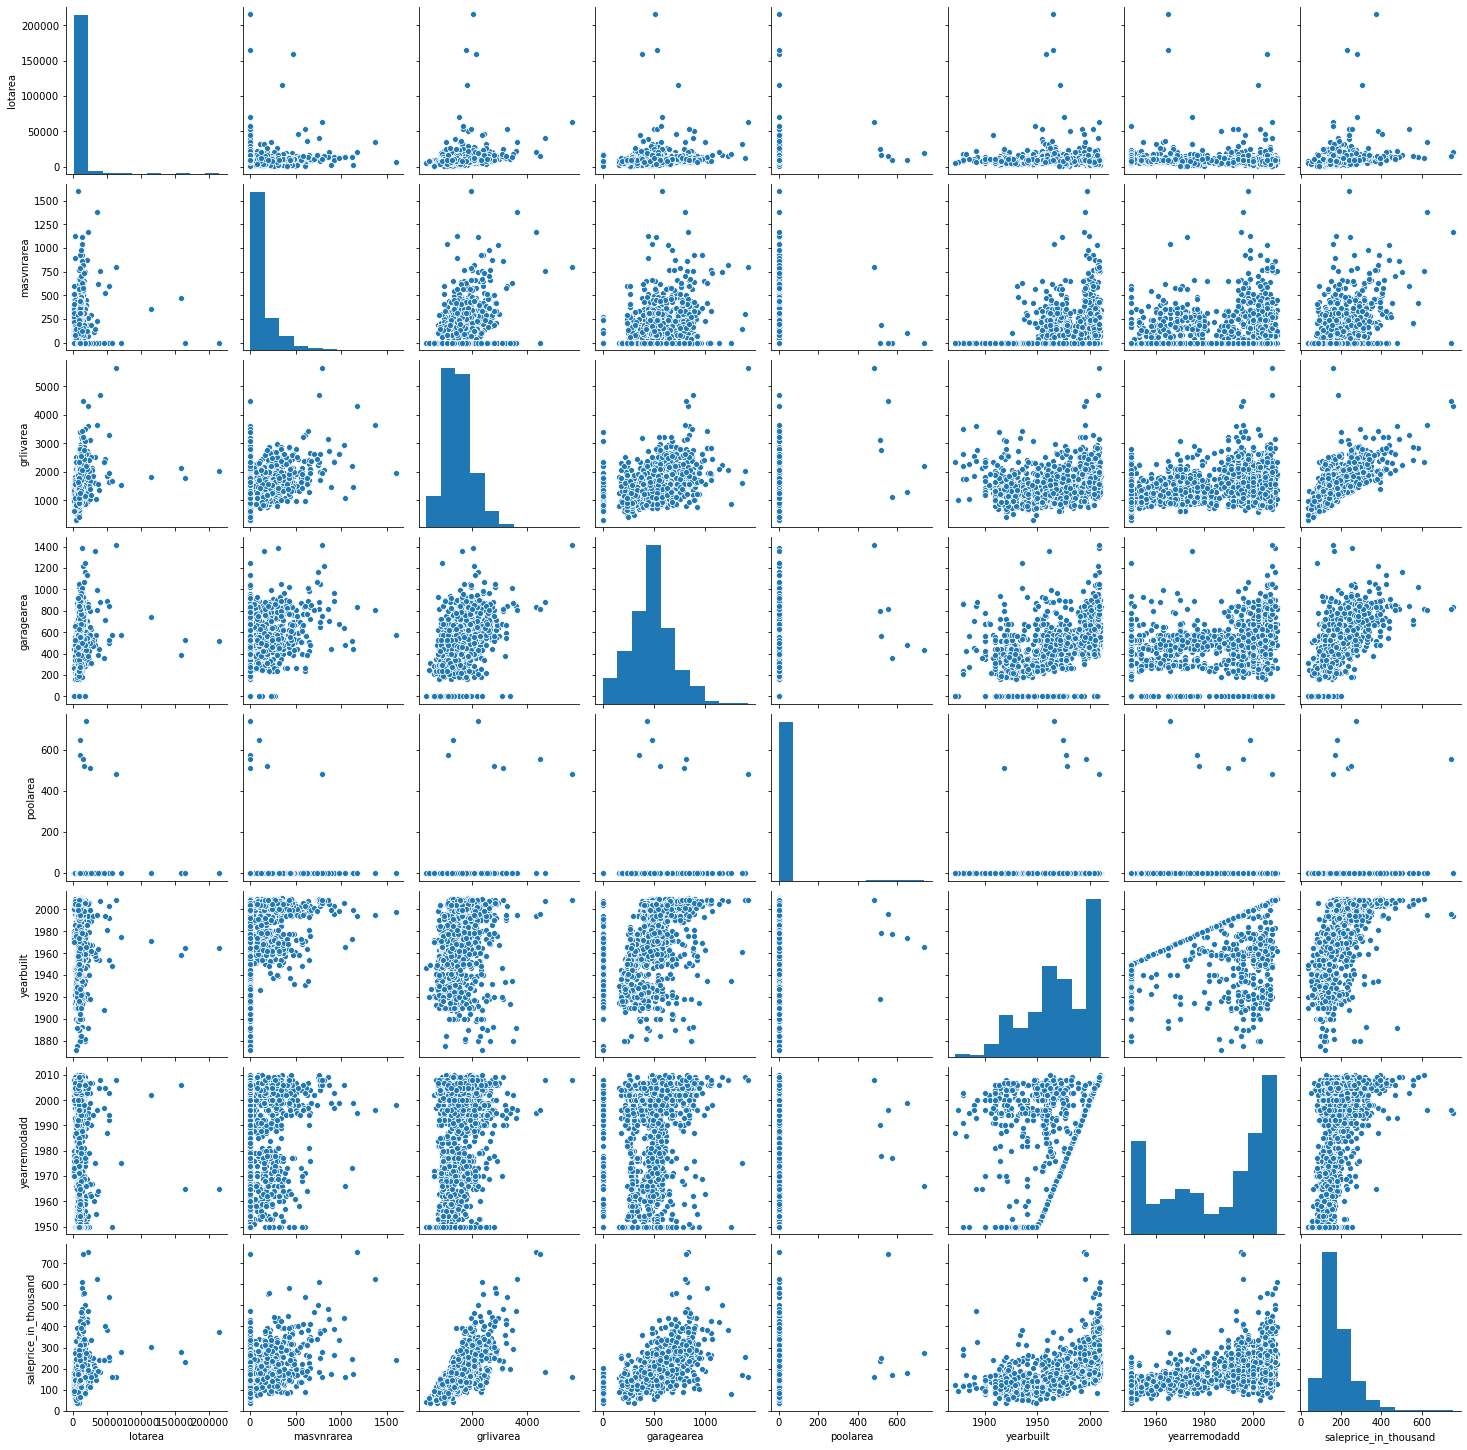

In [13]:
interest_vars = area_vars + ['yearbuilt', 'yearremodadd']
pp = sns.pairplot(train[interest_vars + [target]])

We can see an __upward linear trend__ between: 
+ sale price vs. living area and garage area
+ sale price vs. year built

Another way to look at pairwise relation is to plot correlation matrix via heatmap, with correlation coefs annotated.

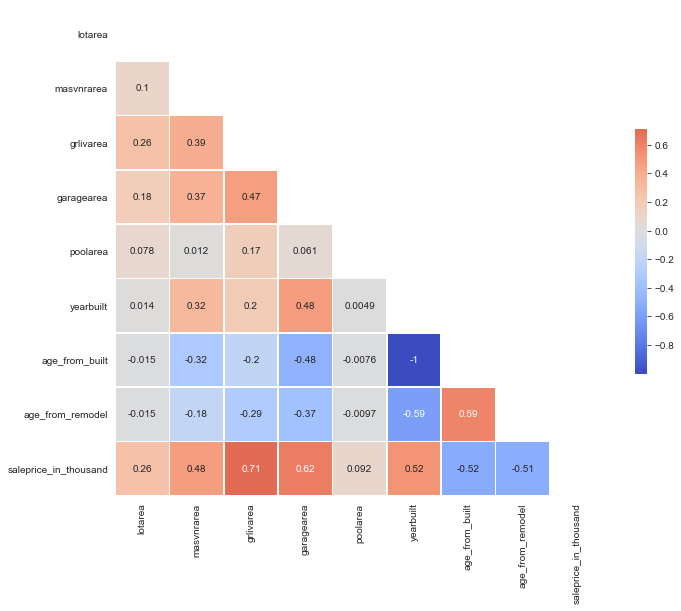

In [118]:
interest_vars = area_vars + ['yearbuilt', 'age_from_built', 'age_from_remodel']
plot_corr_matrix(train[interest_vars + ['saleprice_in_thousand']], 
                 annotate=True, 
                 center=0,
                 color_map=plt.get_cmap('coolwarm'))

Sale price clearly has 
* **high positive** correlation with living area and garage area; 
* **medium positive** correlation with year built and 
* **medium negative** correlation with age from built/remodel

If price per square feet is used instead, we can see a clearer correlation with house age.

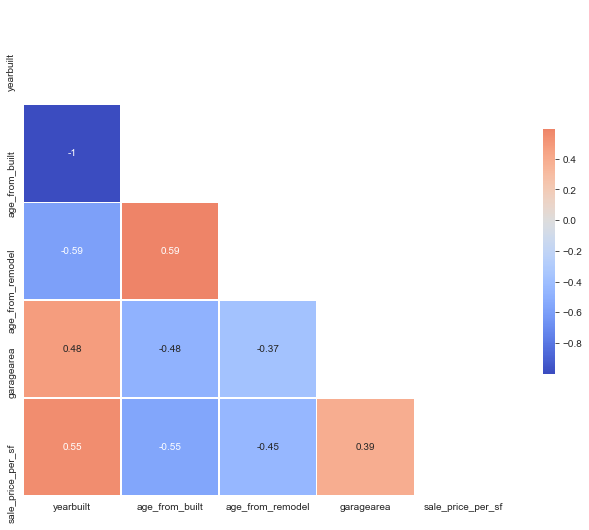

In [127]:
interest_vars = ['yearbuilt', 'age_from_built', 'age_from_remodel', 
                'garagearea'
                ]
plot_corr_matrix(train[interest_vars + ['sale_price_per_sf']], 
                 annotate=True,
                 center=0,
                 color_map=plt.get_cmap('coolwarm'))

## Correlation with other area-related variables

In [37]:
# vars related to area in square feet
sf_vars = [s for s in num_vars if 'sf' in s]
print(sf_vars)

['bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'wooddecksf', 'openporchsf', 'sale_price_per_sf']


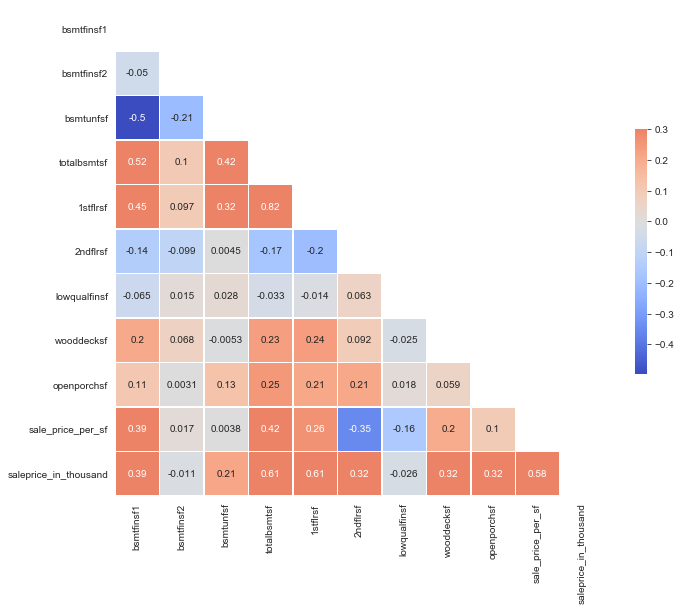

In [38]:
plot_corr_matrix(train[sf_vars + [target]], annotate=True, color_map=plt.get_cmap('coolwarm'))

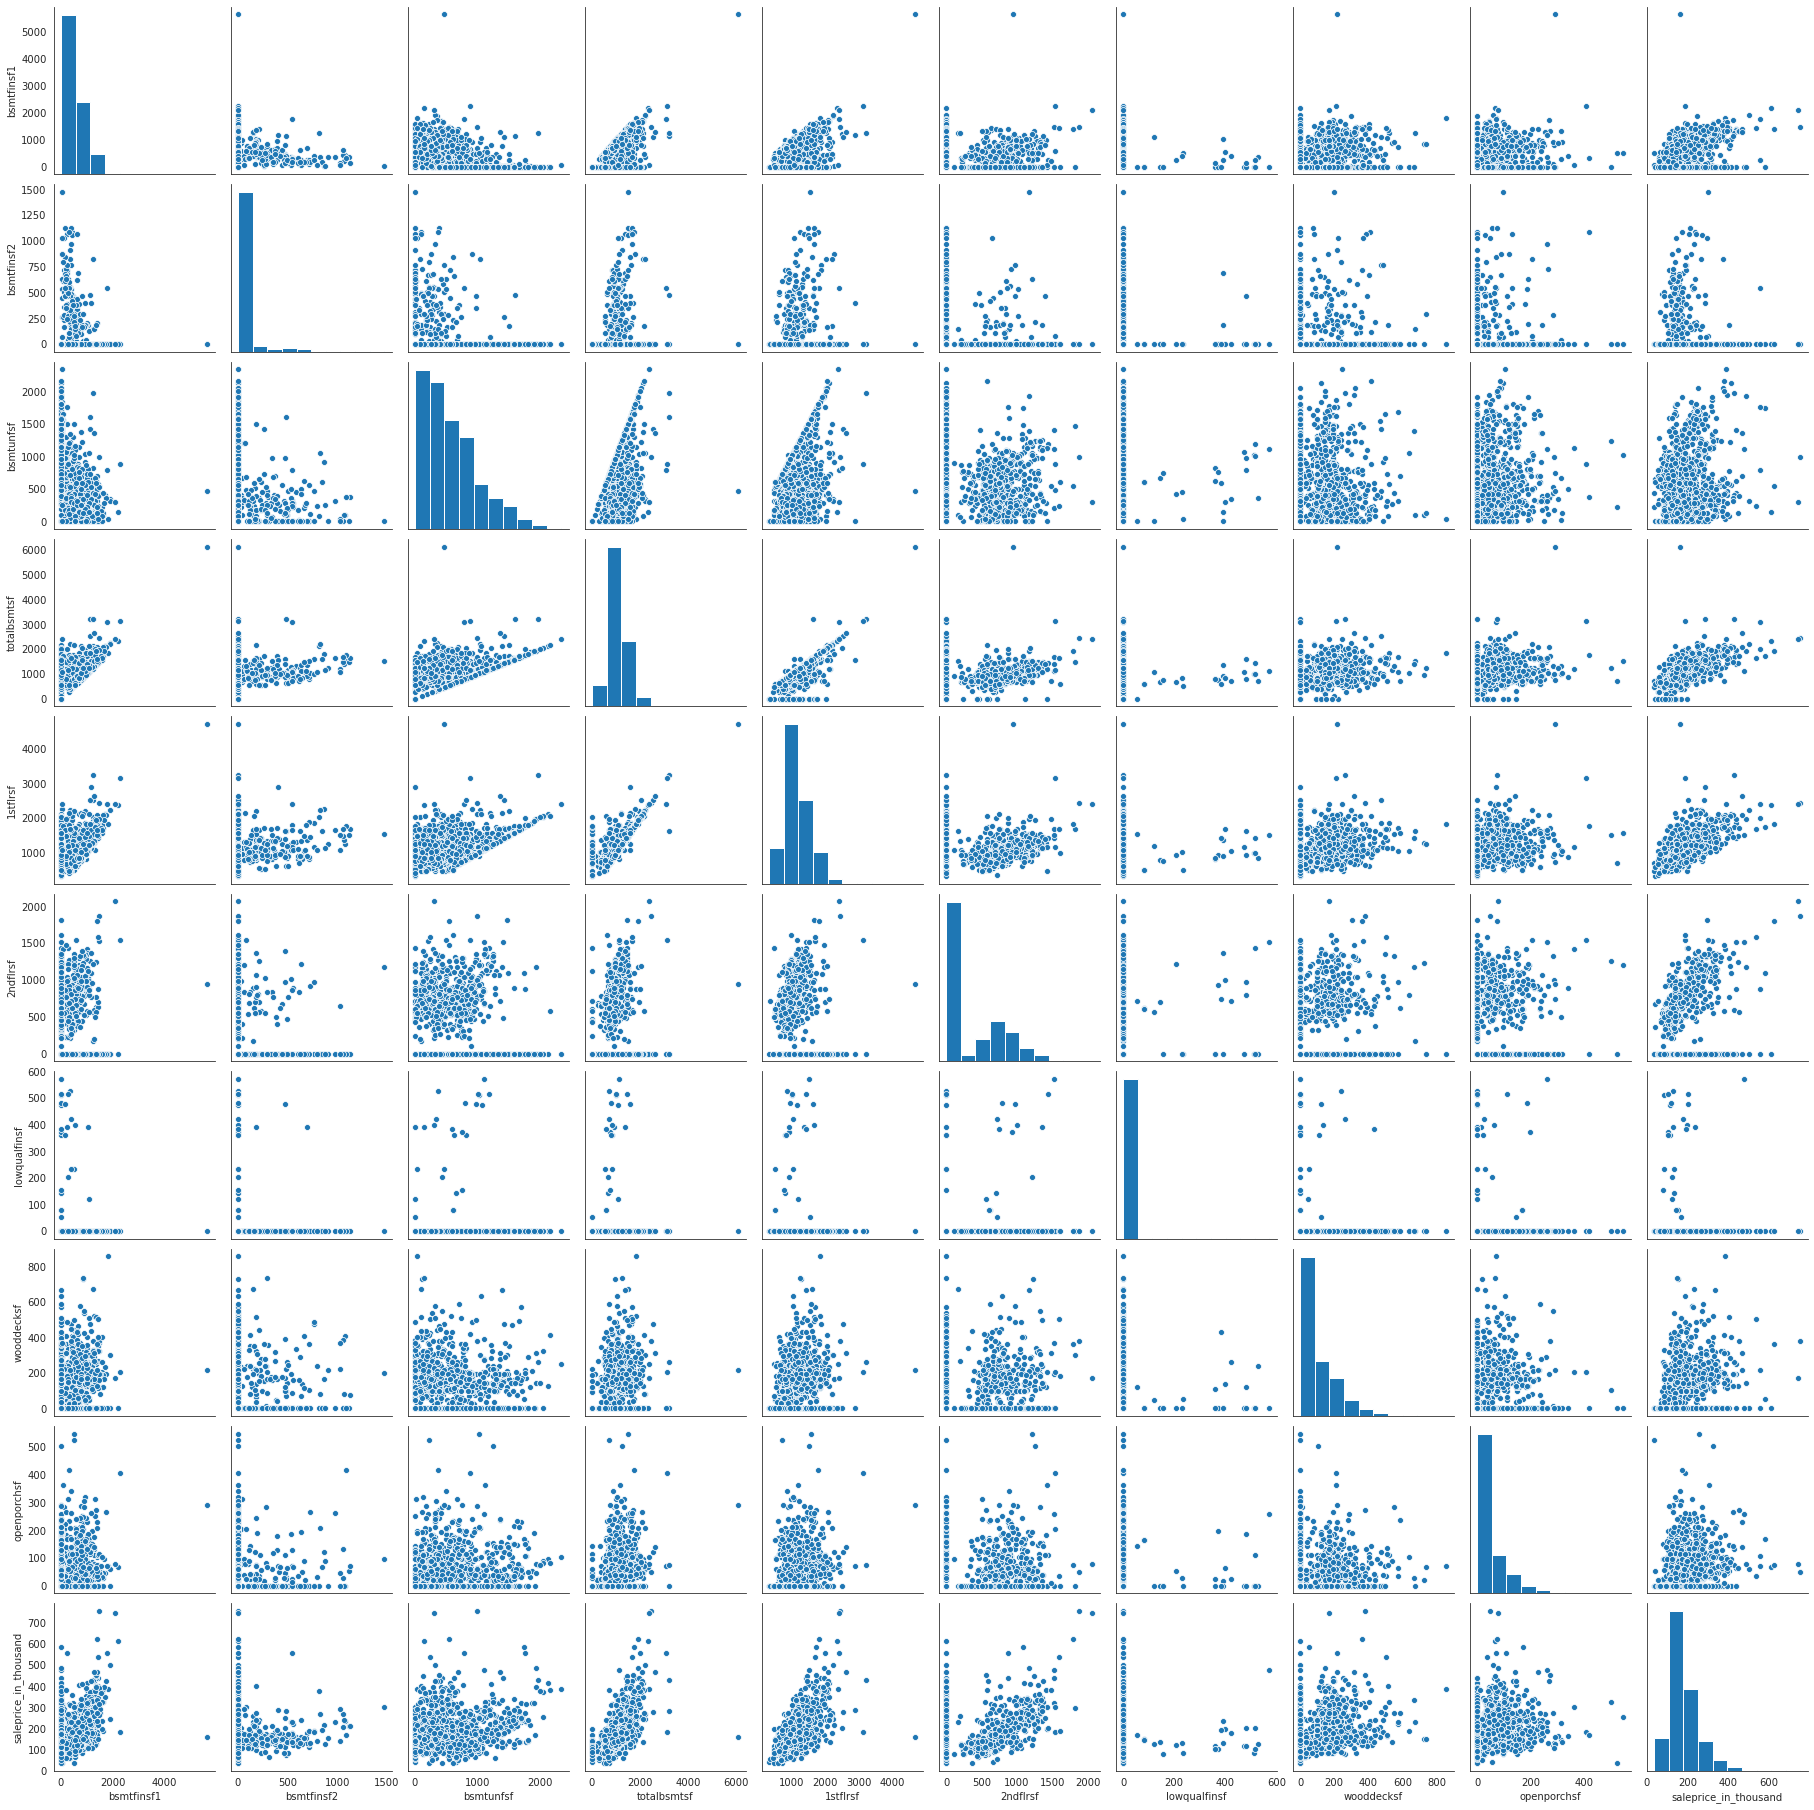

In [21]:
pp2 = sns.pairplot(train[sf_vars + [target]])

+ Sale price has high correlation with area of basement and first floor.
+ Correlatoin matrix is a much better option than pairplot when there are many vars involved.

# Sale price vs. categorical features

In [39]:
cat_vars = train.columns[np.where(train.dtypes == 'object')]
print('# categorical vars: ', len(cat_vars))
print(cat_vars)

# categorical vars:  43
Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')


In [43]:
train['mszoning'].value_counts(dropna=False)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64

+ As RL and RM types are majority, I will collapse other types into a single type named Other.
+ Also need to check if  test set has the same distribution of zone type

In [41]:
test.mszoning.value_counts()

RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: mszoning, dtype: int64

Train and test sets really have similar distribution of zone types. So we can do the same collapsing on test set.

## Distribution of sale price over zone type

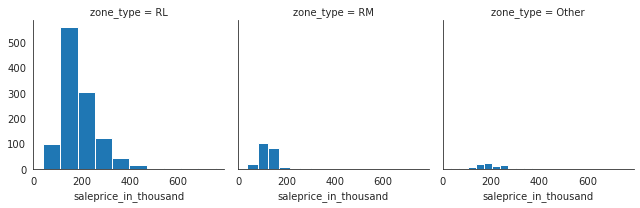

In [25]:
gg = sns.FacetGrid(data=train, col='zone_type')
_ = gg.map(plt.hist, 'saleprice_in_thousand')

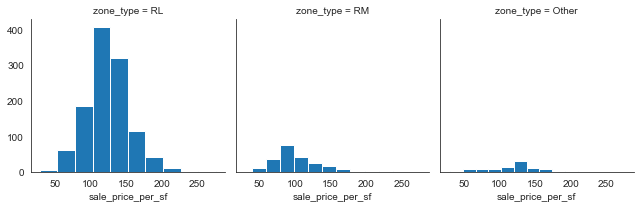

In [45]:
gg = sns.FacetGrid(data=train, col='zone_type')
_ = gg.map(plt.hist, 'sale_price_per_sf')

Sale prices tend to drop when density increase.

## Distribution of sale price over various conditions

In [46]:
train.condition1.value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: condition1, dtype: int64

To get more cases for minority conditions, I will
+ collapse all railroad 
+ collapse all positive cond 

In [47]:
train['adjacency'] = train['condition1'].apply(to_adjacency)
test['adjacency'] = test['condition1'].apply(to_adjacency)

As normal houses form majority, I temp exclude them.

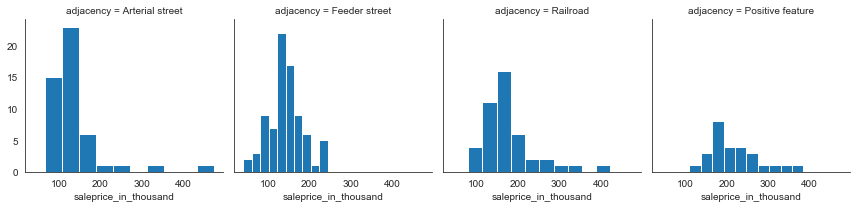

In [48]:
gg = sns.FacetGrid(data=train[train.adjacency!='Normal'] , 
                   col='adjacency', 
                   col_order=['Arterial street', 'Feeder street', 'Railroad', 'Positive feature']
                  )
_ = gg.map(plt.hist, 'saleprice_in_thousand')

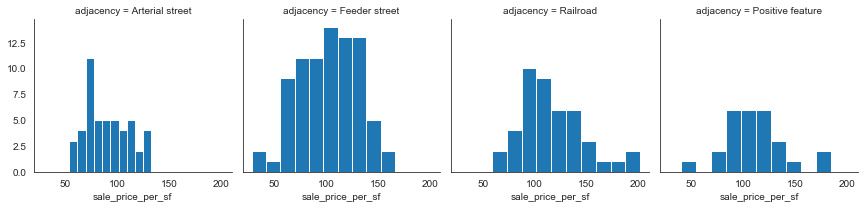

In [50]:
gg = sns.FacetGrid(data=train[train.adjacency!='Normal'] , 
                   col='adjacency', 
                   col_order=['Arterial street', 'Feeder street', 'Railroad', 'Positive feature']
                  )
_ = gg.map(plt.hist, 'sale_price_per_sf')

In [51]:
train.groupby('adjacency')['sale_price_per_sf'].describe()

,count,mean,std,min,25%,50%,75%,max
adjacency,,,,,,,,
Arterial street,48.0,90.292736,21.234958,53.840063,75.635291,85.999745,107.605421,133.008658
Feeder street,81.0,102.378734,29.117654,28.358738,77.262693,100.808625,124.814815,166.621253
Normal,1260.0,123.213573,30.911582,38.510911,103.532126,122.412841,141.181965,276.250881
Positive feature,27.0,111.103554,29.069162,39.510265,95.200650,105.728051,123.615687,184.740883
Railroad,44.0,117.290353,30.952097,58.885384,97.042643,109.683735,135.138471,201.716738


Sale price obviously depend on which type of street a house is adjacent to and if it is close to a park/greenbelt. Especially, if a house is near an arterial street, its price will be dropped due to problems such as air and noise pollutions.

## Association between categorical variables and target

Up to this point, sharp readers may already think: how to measure the correlation between a categorical variable and a continuous target. Here comes eta correlation and its python implementation `dython`.

In [1]:
!pip install dython

In [7]:
from dython.nominal import correlation_ratio
from dython.nominal import associations

In [12]:
cat_feats = list_string_columns(data)
print('# cat feats: ', len(cat_feats))
print(cat_feats)

# cat feats:  43
['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition']


In [13]:
target = 'saleprice'
eta_corrs = [correlation_ratio(train[cf], train[target]) for cf in cat_feats]
corr_target_cat_feats = pd.DataFrame({'cat_feat': cat_feats, 'corr_with_target': eta_corrs
                                     }).sort_values('corr_with_target', ascending=False)
corr_target_cat_feats

,cat_feat,corr_with_target
8,neighborhood,0.738630
18,exterqual,0.690933
21,bsmtqual,0.681905
30,kitchenqual,0.675721
34,garagefinish,0.553059
32,fireplacequ,0.542181
20,foundation,0.506328
33,garagetype,0.499204
24,bsmtfintype1,0.459141
27,heatingqc,0.442154


+ "neighborhood" has very high correlation with target
+ "exterqual" and "kitchenqual" also has high correlation with target

Now, for 10 categorical features with highest correlation with target, we will plot correlation among them to see their relationship.

C:\Users\Victor\Anaconda3\envs\updated\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


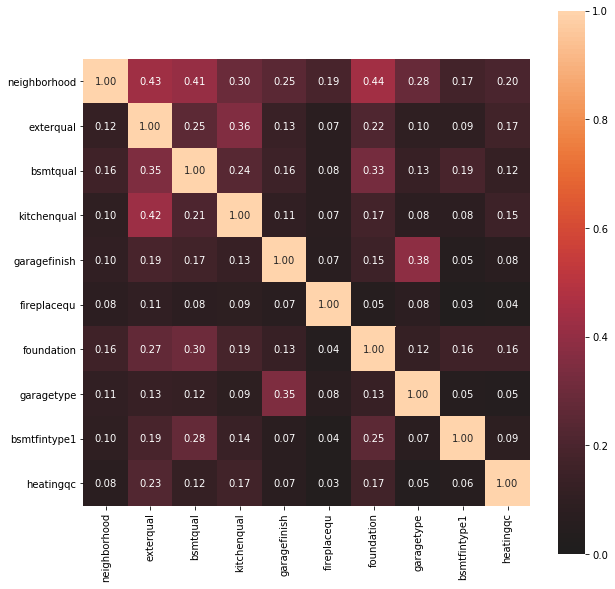

{'corr':               neighborhood  exterqual  bsmtqual  kitchenqual  garagefinish  \
 neighborhood      1.000000   0.431355  0.408822     0.295612      0.245090   
 exterqual         0.123974   1.000000  0.253299     0.358175      0.133508   
 bsmtqual          0.160450   0.345897  1.000000     0.239024      0.155807   
 kitchenqual       0.100108   0.422031  0.206243     1.000000      0.105939   
 garagefinish      0.102720   0.194689  0.166382     0.131111      1.000000   
 fireplacequ       0.081321   0.105419  0.083234     0.089131      0.069539   
 foundation        0.160065   0.273227  0.302127     0.186274      0.131706   
 garagetype        0.108315   0.130083  0.124971     0.091981      0.349166   
 bsmtfintype1      0.100314   0.192360  0.280963     0.135693      0.070998   
 heatingqc         0.076047   0.225379  0.117879     0.169533      0.071053   
 
               fireplacequ  foundation  garagetype  bsmtfintype1  heatingqc  
 neighborhood     0.190973    0.439727    0

In [14]:
# plot corr between 10 cat features with highest corr to target
top10_feats = corr_target_cat_feats.head(10)['cat_feat']
associations(data[top10_feats], theil_u=True, figsize=(10, 10))

## Why certain houses are expensive? cheap?

When we switch from total price to price per square feet, we will obtain the following.

Features of expensive houses:
+ all  (exception 1) are in low density area 
+ newly built
+ most are in NridgHt neighborhood
+ 1-story
+ high overall quality
+ excellent basement quality
+ have excellent equipment, good kitchen and all have central air con

Features of cheap houses:
+ in medium density or commercial areas
+ old houses
+ in neighborhoods Oldtown, Edward and IDOTRR
+ most are 2-story
+ below avg overall quality
+ typical basement quality
+ have so-so equipment, so-so kitchen and not all have central air con

+ garage cond and quality have smaller impact on price

In [55]:
target = 'sale_price_per_sf'

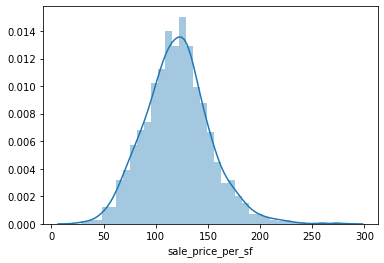

In [19]:
dp = sns.distplot(train.sale_price_per_sf)

In [58]:
train.sale_price_per_sf.describe()

count    1460.000000
mean      120.572878
std        31.391081
min        28.358738
25%        99.822008
50%       120.099031
75%       138.700041
max       276.250881
Name: sale_price_per_sf, dtype: float64

In [59]:
expensive_houses = train.loc[train.sale_price_per_sf > 200]
cheap_houses = train.loc[train.sale_price_per_sf < 50]
common_houses = train.loc[(100 < train.sale_price_per_sf) & (train.sale_price_per_sf < 140)]

In [60]:
print('# expensive houses: ', len(expensive_houses))
print('# cheap houses: ', len(cheap_houses))
print('# common houses: ', len(common_houses))

# expensive houses:  19
# cheap houses:  11
# common houses:  752


In [123]:
interest_cat_vars = ['adjacency', 'mszoning', 'neighborhood', 'age_from_built',
                 'bldgtype', 'housestyle', 
                 'overallqual',
                 'bsmtqual',
#                  'landcontour', 'lotconfig', 'landslope',
#                  'fullbath', 'halfbath', 
#                  'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
                ]

In [124]:
expensive_houses[interest_cat_vars + [target]]

,adjacency,mszoning,neighborhood,age_from_built,bldgtype,housestyle,overallqual,bsmtqual,sale_price_per_sf
53,Normal,RL,Veenker,25,1Fam,1Story,9,Ex,209.011944
151,Normal,RL,NridgHt,1,1Fam,1Story,8,Ex,217.778947
178,Normal,RL,StoneBr,1,1Fam,1Story,9,Ex,224.636079
378,Normal,RL,StoneBr,0,1Fam,1Story,9,Ex,212.517241
440,Normal,RL,NridgHt,1,1Fam,1Story,10,Ex,231.057452
473,Normal,RL,NridgHt,1,1Fam,1Story,8,Ex,222.672065
481,Normal,RL,NridgHt,3,1Fam,1Story,9,Ex,208.705357
644,Normal,FV,Somerst,0,1Fam,1Story,9,Ex,210.010193
664,Railroad,RL,Somerst,1,1Fam,1Story,8,Ex,201.716738
688,Normal,RL,StoneBr,0,1Fam,1Story,8,Gd,276.250881


In [125]:
cheap_houses[interest_cat_vars + [target]]

,adjacency,mszoning,neighborhood,age_from_built,bldgtype,housestyle,overallqual,bsmtqual,sale_price_per_sf
30,Feeder street,C (all),IDOTRR,88,1Fam,2Story,4,TA,30.372058
198,Normal,RM,OldTown,97,1Fam,2.5Fin,6,TA,46.657694
410,Normal,RL,Edwards,51,1Fam,1Story,5,TA,47.021944
495,Normal,C (all),IDOTRR,89,1Fam,1Story,4,TA,48.472222
523,Positive feature,RL,Edwards,0,1Fam,2Story,10,Ex,39.510265
676,Normal,RM,OldTown,106,1Fam,2Story,4,TA,49.041714
809,Normal,RM,OldTown,111,1Fam,2.5Unf,5,TA,49.579046
968,Normal,RM,OldTown,99,1Fam,1.5Fin,3,TA,39.152893
1062,Normal,RM,OldTown,107,2fmCon,2Story,5,TA,38.510911
1292,Normal,RM,OldTown,117,1Fam,2Story,5,TA,45.320405


### Price vs. equipment

In [110]:
equip_vars = [ 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'garagequal', 'garagecond', 
#               'fence',
             ]

In [108]:
expensive_houses[equip_vars]

,heatingqc,centralair,electrical,kitchenqual,garagequal,garagecond,fence
53,Gd,Y,SBrkr,Gd,TA,TA,NaN
151,Ex,Y,SBrkr,Gd,TA,TA,NaN
178,Ex,Y,SBrkr,Ex,TA,TA,NaN
378,Ex,Y,SBrkr,Ex,TA,TA,NaN
440,Ex,Y,SBrkr,Ex,TA,TA,NaN
473,Ex,Y,SBrkr,Gd,TA,TA,NaN
481,Ex,Y,SBrkr,Ex,TA,TA,NaN
644,Ex,Y,SBrkr,Ex,TA,TA,NaN
664,Ex,Y,SBrkr,Ex,TA,TA,NaN
688,Ex,Y,SBrkr,Gd,TA,TA,NaN


In [111]:
cheap_houses[equip_vars]

,heatingqc,centralair,electrical,kitchenqual,garagequal,garagecond
30,TA,N,SBrkr,TA,TA,Fa
198,Ex,Y,SBrkr,TA,NaN,NaN
410,TA,Y,FuseA,TA,TA,TA
495,TA,N,FuseA,TA,NaN,NaN
523,Ex,Y,SBrkr,Ex,TA,TA
676,Fa,N,SBrkr,TA,Fa,Fa
809,TA,N,FuseA,TA,Fa,Po
968,Fa,N,SBrkr,TA,NaN,NaN
1062,TA,N,SBrkr,TA,TA,TA
1292,TA,N,SBrkr,TA,TA,TA
